In [1]:
# ライブラリーのインポート
import warnings
warnings.filterwarnings('ignore')

import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from plotly import tools
from plotly.graph_objs import Bar, Figure, Layout, Scatter
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
import plotly
init_notebook_mode(connected=True)
save_image = None # 'png' if save image

df = pd.read_csv('./train/PAC_Total_1412.csv')


In [3]:
df=df[['Date','amount']]
df.head()

Date       amount
0  2010/1/1  105639.2912
1  2010/2/1  111807.9553
2  2010/3/1  146829.8900
3  2010/4/1  103340.4407
4  2010/5/1  123905.1050

In [4]:
# float型に変換
df['amount'] = df['amount'].astype('float64')
# datetime型にしてインデックスにする
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")


In [5]:
df.head()

amount
Date                   
2010-01-01  105639.2912
2010-02-01  111807.9553
2010-03-01  146829.8900
2010-04-01  103340.4407
2010-05-01  123905.1050

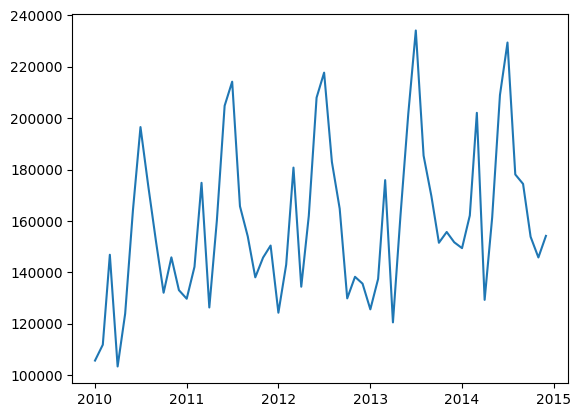

In [6]:
# データの可視化
plt.plot(df.amount)
plt.show()

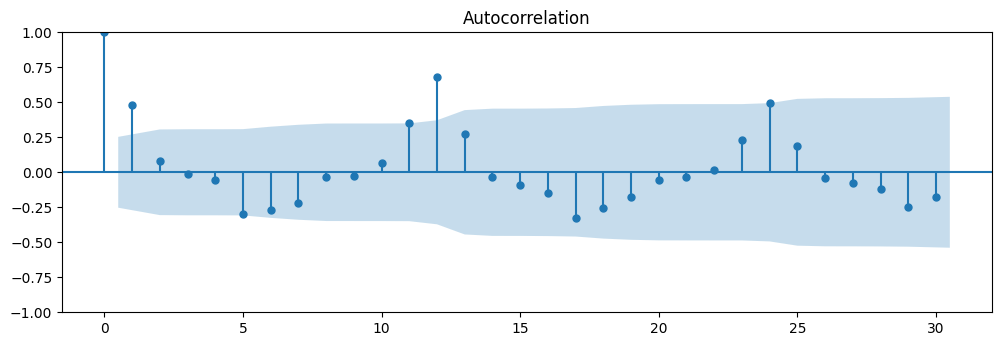

In [7]:
# コレログラム
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.amount, lags=30, ax=ax1)


In [8]:
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.amount, lags=20, ax=ax2)   #出ない

In [9]:
res = sm.tsa.stattools.adfuller(df.amount)
print('p-value = {:.4}'.format(res[1]))
#p-value = 0.9919
#Passengers: p-value > 0.1なので有意水準10%で帰無仮説（定常性を満たす）は棄却されず、定常ではない

p-value = 0.07452


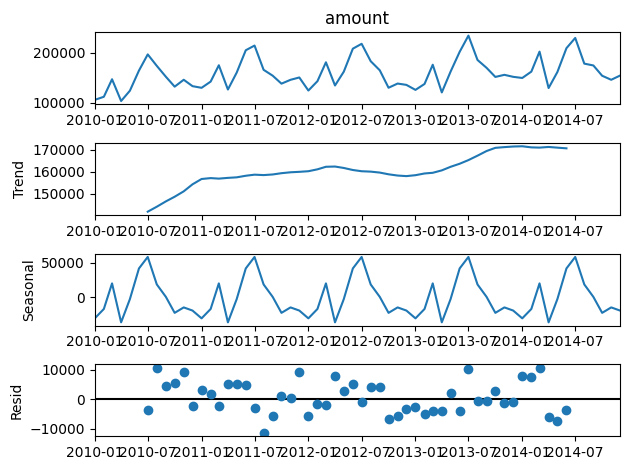

In [10]:
res = sm.tsa.seasonal_decompose(df["amount"])
fig = res.plot()
#本当は差分系列や対数差分系列など、細かい確認が必要

In [11]:
# 学習と評価データに分割
df_train = df[df.index < '2014-01-01']
df_test = df[df.index >= '2014-01-01']

ts = df.amount
ts_train = df_train.amount
ts_test = df_test.amount


print(f' df_train: { len(df_train) }   df_test : { len(df_test) } ')
ts_test

 df_train: 48   df_test : 12 


Date
2014-01-01    149398.3286
2014-02-01    162105.7275
2014-03-01    202075.8278
2014-04-01    129269.9066
2014-05-01    161296.9635
2014-06-01    208999.3383
2014-07-01    229434.1102
2014-08-01    178082.4939
2014-09-01    174403.8429
2014-10-01    153834.2769
2014-11-01    145776.0459
2014-12-01    154167.5857
Name: amount, dtype: float64

In [12]:
import itertools
 
# 各パラメータの範囲を決める
p = d = q = range(0, 3)
sp = sd = sq = range(0, 3)
 
# p, d, q　の組み合わせを列挙するリストを作成
pdq = list(itertools.product(p, d, q))
 
# P, D, Q　の組み合わせを列挙するリストを作成すると同時に、後ろに　s = 12　を決め打ちでつけている。
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))]

In [13]:
import warnings
warnings.filterwarnings("ignore") # warnings を表示させないようにする


# count = 0
# mape_min = 100
# best_result = [0, 0, 10000000]  # MAPEの初期値として大きい値をいれておく
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = SARIMAX(ts_train,
#                           order = param,                 # p d q をセット
#                           seasonal_order=param_seasonal, # P D Q をセット
#                           enforce_stationarity=True,    # enforce_stationarity 推定されるAR部分が定常性を持つように強制する
#                           enforce_invertibility=True)   # enforce_invertibility 推定されるMA部分が反転可能性を持つように強制する
 
#             results = mod.fit()

#             test_pred = results.forecast(len(ts_test))
#             df_pred = pd.DataFrame(test_pred)  #予測値をdfへ
#             df_pred_reset = df_pred.reset_index()  
#             df_test_reset = df_test.reset_index()

#             MAPE = 0
#             for i in range(len(df_test_reset)):
#                 MAPE +=  np.abs(  df_test_reset.iloc[i,1] -   df_pred_reset.iloc[i,1]  )  / df_test_reset.iloc[i,1]  * 100
#             MAPE /= len(df_test_reset)
             
#             #print('order{}, s_order{} - AIC: {}'.format(param, param_seasonal, results.aic))
#             print('order{}, s_order{} - AIC: {} - MAPE: {}  BEST: {}{}{}'.format(param, param_seasonal,results.aic, MAPE,best_result[0],best_result[1],best_result[2]))
#             count += 1

#             if MAPE < best_result[2]:
#                 print(count)
#                 best_result = [param, param_seasonal, MAPE]

#             # if results.aic < best_result[2]:
#             #     best_result = [param, param_seasonal, results.aic ]

#         except:
#             continue
             
# print('最も良いモデル:', best_result)


In [14]:
def eval_model(ts_train, ts_test, result):
    train_pred = result.predict()
    test_pred = result.forecast(len(ts_test))
    test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

    train_rmse = np.sqrt(mean_squared_error(ts_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(ts_test, test_pred))
    print('RMSE(train):\t{:.5}\nRMSE(test):\t{:.5}'.format(
        train_rmse, test_rmse))
    return train_pred, test_pred, test_pred_ci
    
    

In [15]:
# order=(2,0,3)
# seasonal_order=(0,1,1,12)  # MAPE  False   range(0, 4) 最も良いモデル: [(2, 0, 3), (0, 1, 1, 12), 3.881651820281011]  意外とよくない

# MAPE  False   range(0, 3) 最も良いモデル: [(1, 0, 2), (0, 1, 1, 12), 4.069448946913686]
# order=(1,0,2)
# seasonal_order=(0,1,1,12) 

#  MAPE  True   range(0, 4)   最も良いモデル: [(1, 2, 2), (0, 1, 2, 12), 3.904849327482459]
order=(1,2,2)
seasonal_order=(0,1,2,12) 


# order=(2,1,1)
# seasonal_order=(2,2,0,12)  # aic 12.0

model = SARIMAX(
    ts_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=True,
    enforce_invertibility=True)
result = model.fit()
train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
#result.summary()


RMSE(train):	3.0068e+04
RMSE(test):	8344.0


In [16]:

train_pred = result.predict()
test_pred = result.forecast(len(ts_test))
test_pred_ci = result.get_forecast(len(ts_test)).conf_int()

train_rmse = np.sqrt(mean_squared_error(df_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(df_test, test_pred))
print('RMSE(train): {:.5}\nRMSE(test): {:.5}'.format(train_rmse, test_rmse))


RMSE(train): 3.0068e+04
RMSE(test): 8344.0


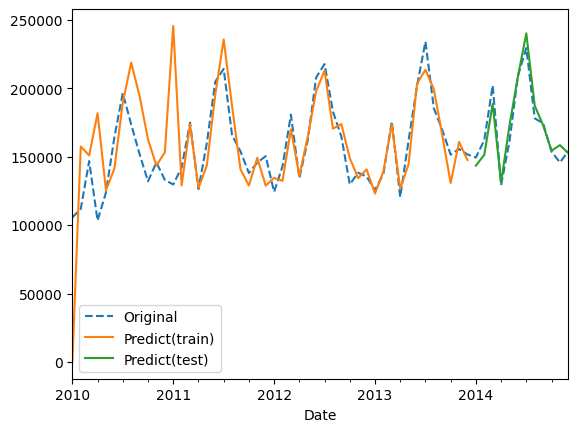

In [17]:

fig, ax = plt.subplots()
df.amount.plot(ax=ax, label='Original', linestyle="dashed")
train_pred.plot(ax=ax, label='Predict(train)')
test_pred.plot(ax=ax, label='Predict(test)')
# ax.fill_between(
#     test_pred_ci.index,
#     test_pred_ci.iloc[:, 0],
#     test_pred_ci.iloc[:, 1],
#     color='k',
#     alpha=.2)
ax.legend()

In [18]:
# sarima_pred = result.predict('2015-01-01', '2016-03-01') 


In [19]:

# plt.figure(figsize=(8, 4))
# plt.plot(df.amount, label="original")
# plt.plot(sarima_pred, c="b", label="model-pred", alpha=0.7)
# plt.legend(loc='best')


In [20]:
model = SARIMAX(
    ts,             # ts: データ全体でfit
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=True,
    enforce_invertibility=True)
result = model.fit()
#train_pred, test_pred, test_pred_ci = eval_model(ts_train, ts_test, result)
#result.summary()

sarima_pred = result.predict('2015-01-01', '2016-03-01')   #予測 


In [21]:
df_sarima_pred = pd.DataFrame(sarima_pred)
df_sarima_pred_reset = df_sarima_pred.reset_index()
df_sarima_pred_reset['Item'] ='PAC_TOTAL'
df_sarima_pred_reset = df_sarima_pred_reset.rename(columns={'index': 'Date'  , 'predicted_mean':'amount_forecast'})
print(df_sarima_pred_reset)
df_sarima_pred_reset.to_csv('sarima.csv' , index=False)


         Date  amount_forecast       Item
0  2015-01-01    150085.648437  PAC_TOTAL
1  2015-02-01    162150.920833  PAC_TOTAL
2  2015-03-01    200601.886371  PAC_TOTAL
3  2015-04-01    128129.835361  PAC_TOTAL
4  2015-05-01    156931.573942  PAC_TOTAL
5  2015-06-01    203796.125308  PAC_TOTAL
6  2015-07-01    220479.500866  PAC_TOTAL
7  2015-08-01    170037.026871  PAC_TOTAL
8  2015-09-01    164278.698078  PAC_TOTAL
9  2015-10-01    140228.689735  PAC_TOTAL
10 2015-11-01    131717.109174  PAC_TOTAL
11 2015-12-01    138390.785364  PAC_TOTAL
12 2016-01-01    132155.664998  PAC_TOTAL
13 2016-02-01    142667.083394  PAC_TOTAL
14 2016-03-01    179413.429848  PAC_TOTAL


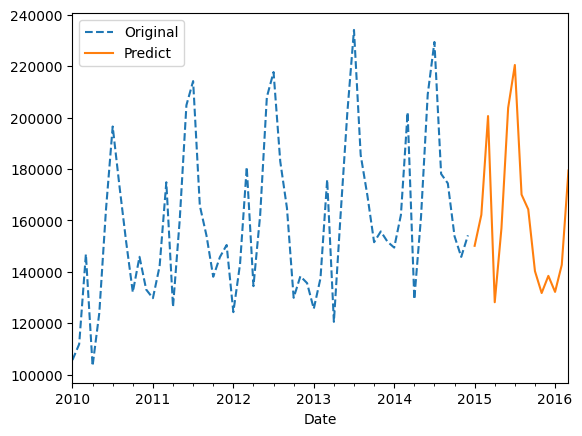

In [22]:
fig, ax = plt.subplots()
df.amount.plot(ax=ax, label='Original', linestyle="dashed")
sarima_pred.plot(ax=ax, label='Predict')
ax.legend()

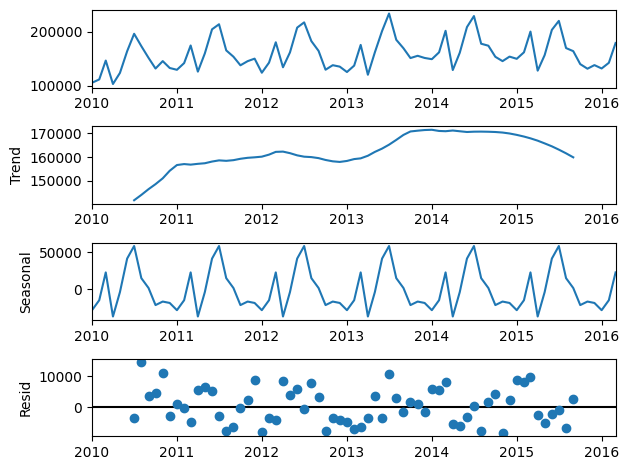

In [23]:
df_sarima_pred = df_sarima_pred.rename(columns={'index': 'Date'  , 'predicted_mean':'amount'})
df = df.append(df_sarima_pred)
res = sm.tsa.seasonal_decompose(df)
fig = res.plot()